In [81]:

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from anytree import RenderTree,Resolver, ChildResolverError
from lib.tree_functions import import_tree_from_json
from lib.config import pipeline_name, db_name, tree_json_path
import tempfile
from lib import count_plot
import networkx as nx

base_url = "https://cdl-segg.fra1.cdn.digitaloceanspaces.com/cdl-segg/"

### Download Section Tree

In [2]:
tree_url = base_url + tree_json_path
response = requests.get(tree_url)
response.raise_for_status()
with tempfile.NamedTemporaryFile(delete=False, suffix=".json") as temp_file:
    temp_file.write(response.content)
    path = temp_file.name
    root_node = import_tree_from_json(path)

for pre, fill, node in RenderTree(root_node):
    print(f"{pre}{node.name} ({node.data_id})")

Pimp my School Downloads (36)
├── 1.1. Was ist Schülervertretungsarbeit (38)
├── 1.2. Rechtliche Grundlagen (39)
│   ├── Mecklenburg-Vorpommern (41)
│   ├── Nordrhein-Westfalen (52)
│   │   └── Erlasse (55)
│   ├── Sachsen-Anhalt (53)
│   ├── Berlin (56)
│   │   ├── Besonderheiten Berufsschulen (57)
│   │   ├── Formales für Gremien (58)
│   │   └── Schülervertretung in Bezirk und Land (59)
│   ├── Hessen (132)
│   ├── Brandenburg (153)
│   └── Besonderheiten an einzelnen Schulformen (42)
│       ├── Oberstufenzentren (OSZ) (159)
│       ├── Grundschulen (173)
│       └── Berufsschule (176)
├── 1.3. Mögliche Aktionen, Themen und Projekte von A-Z (46)
│   ├── Unterricht verändern (47)
│   ├── Projektideensammlungen zur Inspiration (111)
│   ├── Aktionen und Projekte (Beschreibungen) (51)
│   │   ├── Lesenacht (105)
│   │   ├── Party (106)
│   │   ├── Schulball (107)
│   │   ├── Schülernachhilfe-Pool (108)
│   │   ├── Valentinstag (109)
│   │   ├── Schülerfirma (160)
│   │   └── Vera

In [143]:
resolver = Resolver('data_id')
test = resolver.get(root_node, "41")
test.children

ChildResolverError: AnyNode(data_id='36', data_level='0', data_parent_id='0', name='Pimp my School Downloads') has no child 41. Children are: '38', '39', '46', '54', '60', '61', '62', '63', '64', '65', '66', '68', '69', '70', '71', '72', '73', '74', '75', '76', '79', '80'.

### Download Files

In [103]:
posts_url = base_url + "downloads.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

data_id,data_category_id,title,category_title,download_link,file_type,file_binary
i64,i64,str,str,str,str,binary
3882,81,"""Mecklenburg-Vorpommern_SV-Hand…","""Handbücher""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.3\x0a%\xe2\xe3\xcf\xd3\x0a1\x200\x20obj\x0a<</Producer(Acrobat\x20Distiller\x204.05\x20fo""…"
4116,107,"""We have great news!""","""Schulball""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.4\x0a%\xf6\xe4\xfc\xdf\x0a1\x200\x20obj\x0a<<\x0a/Type\x20/Catalog\x0a/Pages\x202\x200\x20R\x0a>>\x0aend""…"
4203,118,"""Newsletter erstellen (SJB)""","""SV-Newsletter""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.5\x0d\x0a%\xb5\xb5\xb5\xb5\x0d\x0a1\x200\x20obj\x0d\x0a<</Type/Catalog/Pages\x202\x200\x20R/Lang(d""…"
3944,88,"""Wahlprotokoll_ausführlich""","""2.1.1. Klassensprecher_innen""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.5\x0d\x0a%\xb5\xb5\xb5\xb5\x0d\x0a1\x200\x20obj\x0d\x0a<</Type/Catalog/Pages\x202\x200\x20R/Lang(d""…"
3943,88,"""Vorlage. Wahlprotokoll""","""2.1.1. Klassensprecher_innen""","""https://meinsvwissen.de/downlo…","""pdf""","b""%PDF-1.4\x0a%\xc3\xa4\xc3\xbc\xc3\xb6\xc3\x9f\x0a2\x200\x20obj\x0a<</Length\x203\x200\x20R/Filter/FlateDecod""…"


In [ ]:
dl_df = df.clone()

In [110]:
len(dl_df)

594

In [4]:
df["file_type"].value_counts().sort("count", descending=True)

file_type,count
str,u32
"""pdf""",44
"""octet-stream""",5
"""mp4""",3


### Posts

In [142]:
posts_url = base_url + "smoke_test_posts.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

id,date,title,stage,tool_types,topics,download_chapter_dedicated,download_chapters_further,book_chapter,related_posts,associated_downloads
i64,date,str,str,list[cat],list[str],i64,list[i64],str,list[i64],list[i64]
6198,2025-07-16,"""SV-Sitzungen""","""sv-alltag""","[""praesentation""]","[""ideenfindung"", ""motivation"", ""sitzungen""]",69,[],"""https://meinsvwissen.de/wp-con…","[4791, 6588, … 6954]","[4054, 4040, … 4042]"
8952,2025-07-31,"""Memory-Spiel: Konferenzen (Mec…","""sv-alltag""","[""download"", ""vorlage""]","[""gremien-konferenzen""]",41,[],null,"[3421, 6588, … 4593]",null
9042,2025-07-31,"""Selbsttest: Wie schülerfreundl…","""sv-alltag""","[""selbsttest""]","[""sitzungen""]",69,[],null,"[6362, 6421, … 3421]","[4054, 4040, … 4042]"
8742,2025-07-29,"""Memory-Spiel: Konferenzen (Ber…","""sv-alltag""","[""download"", ""vorlage""]","[""gremien-konferenzen""]",56,[],null,"[3421, 6588, … 3297]",null
8937,2025-07-31,"""SV-Quiz (Mecklenburg-Vorpommer…","""sv-alltag""","[""download"", ""vorlage""]",[],41,[],null,"[6588, 4891, … 6588]",null


In [106]:
p_df = df.clone()

In [54]:
len(df)

86

In [7]:
df["stage"].value_counts().sort("count", descending=True)

stage,count
str,u32
"""sv-alltag""",31
"""grundlagen""",29
"""fortgeschrittene""",13
"""profis""",8
null,5


In [8]:
df["stage"].unique().to_list()

['profis', 'sv-alltag', 'grundlagen', None, 'fortgeschrittene']

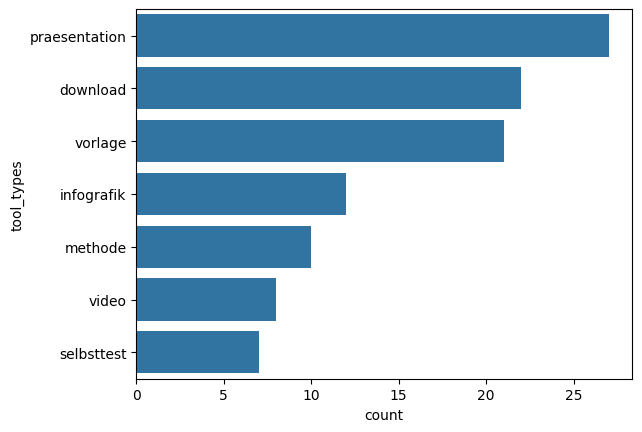

In [9]:
count_plot(df, "tool_types")

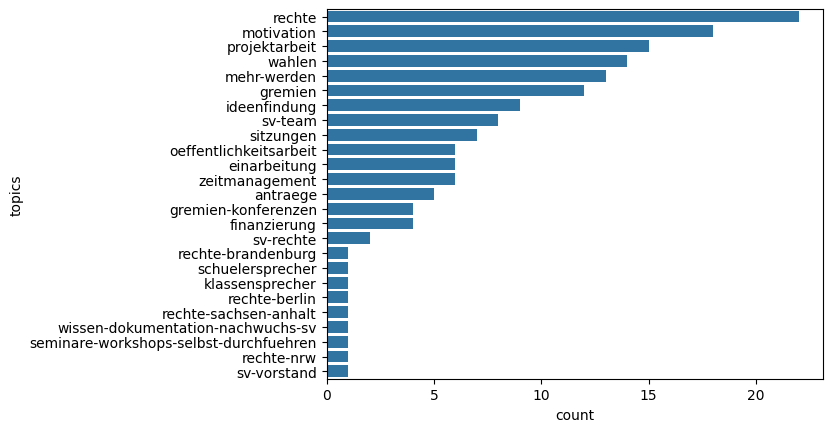

In [10]:
count_plot(df, "topics")

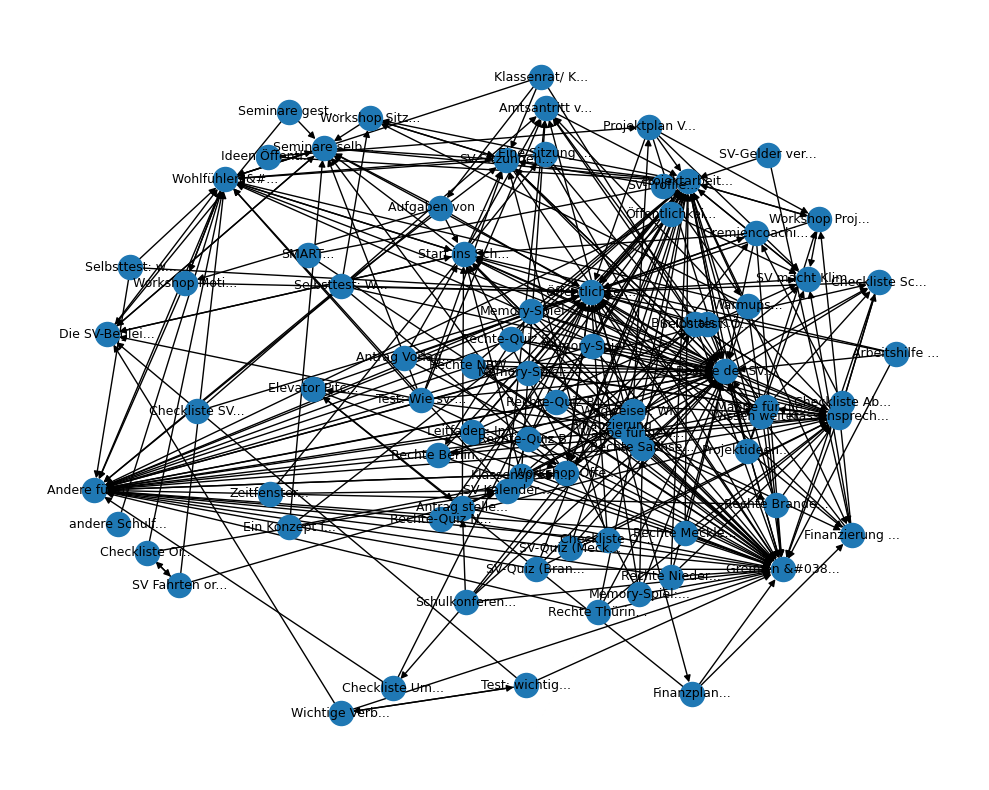

In [11]:
records = df.to_dicts()

G = nx.DiGraph()
for rec in records:
    src = rec["id"]
    G.add_node(src, label=f"{rec['title'][:13]}...")
    for tgt in rec.get("related_posts") or []:
        G.add_edge(src, tgt)

nodes_to_remove = [n for n, d in G.degree() if d <= 1]
G.remove_nodes_from(nodes_to_remove)

# Use spring layout instead of pygraphviz
pos = nx.spring_layout(G, k=1, iterations=50)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(
    G,
    pos,
)
nx.draw_networkx_edges(
    G,
    pos,
)
labels = nx.get_node_attributes(G, "label")
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family="sans-serif")

plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
self_loop_nodes = [n for n in G.nodes() if G.has_edge(n, n)]

# 2. Or via self-loop edges
self_loop_nodes = list({u for u, v in nx.selfloop_edges(G)})

print("Node IDs with self-loops:", self_loop_nodes)


Node IDs with self-loops: []


### Get posts of a download

In [ ]:
dl_dcts = dl_df[["data_id", "data_category_id"]].to_dicts()
p_df_temp = p_df.rename({"download_chapter_dedicated": "data_category_id"})
post_dcts = p_df_temp[["data_category_id", "id"]].to_dicts()

def get_all_category_ids(cat_id):
    """Get this category ID and all descendant category IDs."""
    if cat_id is None:
        return []
    
    category_ids = [cat_id]
    
    try:
        node = resolver.get(root_node, str(cat_id))
        for child in node.children:
            child_id = int(child.data_id)
            category_ids.extend(get_all_category_ids(child_id))
    except ChildResolverError:
        pass
    
    return category_ids

resolver = Resolver('data_id')
found = []

for post in post_dcts:
    post_cat_id = post["data_category_id"]
    post_id = post["id"]
    
    # get all category IDs (post category + all descendants)
    all_cat_ids = get_all_category_ids(post_cat_id)
    
    #find downloads whose category is in this tree
    matched = [
        dl['data_id'] for dl in dl_dcts 
        if dl['data_category_id'] in all_cat_ids
    ]
    
    found.append({post_id: matched})

found

[{3217: [4220,
   9077,
   4221,
   4218,
   4229,
   4222,
   4230,
   4219,
   4227,
   4228,
   4217,
   7500]},
 {6055: []},
 {8961: [6916, 6915]},
 {7081: [7069, 3982, 3979, 7068, 3981, 7067, 7072, 7103, 7071, 7105, 3980]},
 {4946: [4053,
   4050,
   4034,
   4021,
   4038,
   4017,
   4052,
   4043,
   4057,
   4024,
   7544,
   4054,
   4087,
   4042,
   4032,
   4028,
   4056,
   4084,
   4075,
   4033,
   4027,
   4025,
   4081,
   4082,
   4040,
   4063,
   4016,
   4018,
   4086,
   4079,
   4072,
   4077,
   4061,
   4048,
   4083,
   4067,
   4070,
   4078,
   4019,
   4076,
   4035,
   4029,
   4059,
   4071,
   4036,
   4089,
   4023,
   4080,
   4051,
   4031,
   4047,
   4064,
   4066,
   4022,
   4074]},
 {8742: [7268, 3819, 3821, 3817, 7279, 7042]},
 {7401: [3830,
   3838,
   3828,
   3831,
   3833,
   3879,
   3825,
   3834,
   3832,
   3878,
   3835,
   3873,
   3829,
   3837,
   3876,
   3880,
   3827,
   3826]},
 {7022: [3587, 3590, 3586]},
 {4863: []},
 {7159: [

### Sections

In [13]:
posts_url = base_url + "sections.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

post_id,title,text,type,external_link,transcript_url
i64,str,str,cat,str,str
3217,null,"""Einen schriftlichen Antrag zu …","""plain_text""",null,null
3217,"""3.5.3. Einen Antrag stellen""",null,"""h5p""",null,null
6055,null,"""Wenn ihr in eurer Schule etwas…","""plain_text""",null,null
6055,null,null,"""youtube""","""https://www.youtube.com/watch?…",null
6055,null,"""Quelle: https://www.bpb.de/""","""plain_text""",null,null


In [14]:
df["type"].value_counts().sort("count", descending=True)

type,count
cat,u32
"""accordion_section_text""",194
"""plain_text""",92
"""accordion_section_image""",90
"""flipcard""",60
"""accordion_section_prezi""",37
…,…
"""h5p""",26
"""image""",19
"""youtube""",7


### Glossary Terms

In [15]:
posts_url = base_url + "glossary_terms.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

term,definition,DE,DE_BW,DE_BY,DE_BE,DE_BB,DE_HB,DE_HH,DE_HE,DE_MV,DE_NI,DE_NW,DE_RP,DE_SL,DE_SN,DE_ST,DE_SH,DE_TH
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Antrag""","""Ein Antrag ist ein Vorschlag, …",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Aufgabenprofil""","""Ihr schreibt transparent und k…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Auftaktveranstaltung / SV-Tag""","""Start in die SV-Arbeit zu Begi…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Bezirks-/ Kreis & Landesschüle…",null,"""BSK (Bundesschülerkonferenz – …",null,null,"""BSA und LSA (Bezirksschüler- u…","""KSR und LSR (Kreisschüler- und…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""BSV und LSV (Bezirksschüler- u…",null,null,null,"""KSR und LSR (Kreisschüler- und…",null,"""Kreisschülersprecher:innen und…"
"""BSK""","""Bundesschülerkonferenz. Sie be…","""Bundesschülerkonferenz. Sie be…",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


### Publications

In [16]:
posts_url = base_url + "publications.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

key,type,title,authors,abstract,date,url,pdf_binary,jurisdiction,school_type,tags
str,str,str,list[str],str,str,str,binary,cat,cat,list[str]
"""21001957/IZ8U7Z33""","""book""","""Handbuch für Schülervertretung…","[""Kultusministerium des Landes Sachsen-Anhalt""]",null,"""2023""","""https://mb.sachsen-anhalt.de/f…","b""%PDF-1.6\x0d%\xe2\xe3\xcf\xd3\x0d\x0a3248\x200\x20obj\x0d<</Linearized\x201/L\x204287654/O\x203250/""…","""DE_ST""",null,[]
"""21001957/HASTIBCW""","""book""","""Alles was ihr wissen müsst: Ei…","[""Schüler:innenkammer Hamburg""]",null,"""2014""","""https://irp.cdn-website.com/75…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a1691\x200\x20obj\x0d<</Linearized\x201/L\x204144512/O\x201693/""…","""DE_HH""",null,[]
"""21001957/D794UHKJ""","""book""","""Pimp my school : 1x1 der SV-Ar…","[""Felix Scheel""]","""Das Handbuch greift alle klass…","""2023-08""","""https://collections.fes.de/pub…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_MV""",null,[]
"""21001957/8BWQKQXS""","""book""","""Pimp my school : 1x1 der SV-Ar…","[""Felix Scheel""]","""Das Handbuch greift alle klass…","""2020-12""","""https://collections.fes.de/pub…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_NW""",null,[]
"""21001957/KDZX8DD4""","""book""","""Pimp my School : 1x1 der SV-Ar…","[""Felix Scheel""]",null,"""2017""","""https://library.fes.de/pdf-fil…","b""%PDF-1.7\x0d%\xe2\xe3\xcf\xd3\x0d\x0a4814\x200\x20obj\x0d<</Linearized\x201/L\x207810875/O\x204816/""…","""DE_BE""",null,[]


In [17]:
df["type"].value_counts().sort("count", descending=True)

type,count
str,u32
"""book""",21
"""article""",8
"""article-journal""",5
"""chapter""",1
"""report""",1


In [18]:
df["jurisdiction"].value_counts()

jurisdiction,count
cat,u32
"""DE_HB""",1
"""DE_ST""",1
"""DE_HE""",1
"""DE_HH""",1
"""DE_SH""",1
…,…
"""DE_SN""",1
"""DE_BE""",3
"""DE_NI""",1


### Legal Resources

In [19]:
posts_url = base_url + "legal_resources.parquet"
response = requests.get(posts_url)
response.raise_for_status()
df = pl.read_parquet(response.content)
df.head()

url,type,title,html,jurisdiction
str,str,str,str,cat
"""https://gesetze.berlin.de/perm…","""Schulgesetz""","""SchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_BE"""
"""https://bravors.brandenburg.de…","""Schulgesetz""","""BbgSchulG""",""" <ul> <li><a>Ansicht drucken…","""DE_BB"""
"""https://landesrecht.thueringen…","""Schulgesetz""","""ThürSchulG""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://landesrecht.thueringen…","""Schulordnung""","""ThürSchulO""",""" <a name=""DocInhalt""> </a> <…","""DE_TH"""
"""https://www.landesrecht.sachse…","""Schulgesetz""","""SchulG LSA""",""" <a name=""DocInhalt""> </a> <…","""DE_ST"""


In [20]:
df["type"].value_counts(sort=True)

type,count
str,u32
"""Schulgesetz""",14
"""Runderlass""",4
"""Schulordnung""",2
"""Schülermitwirkungsverordnung""",1
"""Schülermitverantwortungsverord…",1
…,…
"""Verordnung zur Gestaltung des …",1
"""Schülerwahlordnung""",1
"""Verwaltungsvorschrift""",1


### Student Council Committees

In [21]:
scc_url = base_url + "student_council_committees.parquet"
response = requests.get(scc_url)
response.raise_for_status()
scc_df = pl.read_parquet(response.content)
scc_df.head()

name,description,website,jurisdiction
str,str,str,cat
"""Bundesweit""","""Die Bundesschülerkonferenz ist…","""https://www.bundesschuelerkonf…","""DE"""
"""Baden-Württemberg""","""Der Landesschülerbeirat (LSBR)…","""https://lsbr.de/""","""DE_BW"""
"""Bayern""","""Die SchĂĽlermitverantwortung (…","""https://www.facebook.com/lsrba…","""DE_BY"""
"""Brandenburg""","""Beim Landesschüler*innenrat Br…","""https://www.lsr-brandenburg.de""","""DE_BB"""
"""Berlin""","""Der Landesschüler*innenausschu…","""https://lsaberlin.de/""","""DE_BE"""


In [22]:
print(f"Total SCC entries: {len(scc_df)}")
print(f"Jurisdictions covered: {len(scc_df['jurisdiction'].unique())}")
print("Sample jurisdictions:", scc_df['jurisdiction'].unique().to_list()[:5])

Total SCC entries: 17
Jurisdictions covered: 17
Sample jurisdictions: ['DE', 'DE_BW', 'DE_BY', 'DE_BB', 'DE_BE']


### SV tipps

In [23]:
svtipps_url = base_url + "svtipps.parquet"
response = requests.get(svtipps_url)
response.raise_for_status()
svtipps_df = pl.read_parquet(response.content)
svtipps_df.head()

title,url,html_content,category,subcategory
str,str,str,str,str
"""Struktur – SVTipps – Von Schül…","""https://svtipps.de/struktur/""","""<h1>Struktur</h1><p>Ihr wollt,…","""Struktur""",null
"""Die Schülervertretung – SVTipp…","""https://svtipps.de/struktur/di…","""<h1>Die Schülervertretung</h1>…","""Struktur""",null
"""Schulsprecher*in – SVTipps – V…","""https://svtipps.de/struktur/sc…","""<h1>Schulsprecher*in</h1><p>Di…","""Struktur""",null
"""Klassensprecher*in & Stufenspr…","""https://svtipps.de/struktur/kl…","""<h1>Klassensprecher*in &amp; S…","""Struktur""",null
"""Kassenwart – SVTipps – Von Sch…","""https://svtipps.de/struktur/ka…","""<h1>Kassenwart</h1><p>Der Kass…","""Struktur""",null


In [24]:
print(f"Total SVTipps entries: {len(svtipps_df)}")
print(f"Categories: {len(svtipps_df['category'].unique())}")
svtipps_df['category'].value_counts().head()

Total SVTipps entries: 97
Categories: 7


category,count
str,u32
"""Struktur""",8
"""Projektmanagement""",5
"""Großprojekte""",39
"""Kleinprojekte""",31
"""Management""",8
